In [1]:
using Distributions
using StatsPlots
default(titlefontsize=12, fmt=:png)
using Roots
using Random
using StatsBase
using Memoization

In [2]:
name(dist::UnivariateDistribution) = replace(string(dist), r"{[^{.]*}"=>"")

function cdfordstat(dist, n, k, x)
    beta = Beta(k, n-k+1)
    cdf(beta, cdf(dist, x))
end

prevx(x::AbstractFloat) = prevfloat(x)
prevx(x::Integer) = x - 1
pmfordstat(dist, n, k, x) = cdfordstat(dist, n, k, x) - cdfordstat(dist, n, k, prevx(x))

function quantileordstat(dist, n, k, p)
    beta = Beta(k, n-k+1)
    quantile(dist, quantile(beta, p))
end

pmfmedian(dist, n, a) = pmfordstat(dist, n, (n+1)/2, a)
cdfmedian(dist, n, a) = cdfordstat(dist, n, (n+1)/2, a)
quantilemedian(dist, n, p) = quantileordstat(dist, n, (n+1)/2, p)
pvalmedian(dist, n, a) = min(1, 2cdfmedian(dist, n, a), 2(1 - cdfmedian(dist, n, prevx(a))))

function empiricaldist_allowrep(X) # very slow
    c = countmap(X)
    u = collect(keys(c))
    w = values(c) ./ length(X)
    DiscreteNonParametric(u, w) 
end
empiricaldist(X) = DiscreteNonParametric(X, fill(1/length(X), length(X)))

pmfmedian(X, a) = pmfmedian(empiricaldist(X), length(X), a)
cdfmedian(X, a) = cdfmedian(empiricaldist(X), length(X), a)
pvalmedian(X, a) = min(1, 2cdfmedian(X, a), 2(1 - cdfmedian(X, prevx(a))))

pmfmedian_allowrep(X, a) = pmfmedian(empiricaldist_allowrep(X), length(X), a)
cdfmedian_allowrep(X, a) = cdfmedian(empiricaldist_allowrep(X), length(X), a)
pvalmedian_allowrep(X, a) = min(1, 2cdfmedian_allowrep(X, a), 2(1 - cdfmedian(X, prevx(a))))

function cimedian_old(sampledist::DiscreteNonParametric, n; α = 0.05) # very slow
    f(x) = cdfmedian(sampledist, n, x)
    L = find_zeros(x -> f(x) - α/2,       extrema(sampledist)...)[begin]
    U = find_zeros(x -> f(x) - (1 - α/2), extrema(sampledist)...)[end]
    L, U
end

function cimedian(sampledist::DiscreteNonParametric, n; α = 0.05)
    L = quantilemedian(sampledist, n, α/2)
    U = quantilemedian(sampledist, n, 1 - α/2)
    L, U
end

function cimedian(X; α = 0.05)
    n = length(X)
    sampledist = empiricaldist(X)
    cimedian(sampledist, n; α)
end

function cimedian_allowrep(X; α = 0.05)
    n = length(X)
    sampledist = empiricaldist_allowrep(X)
    cimedian(sampledist, n; α)
end

function plot_randmedianci(dist, n; α = 0.05)
    X = rand(dist, n)
    sampledist = empiricaldist(X)
    a, b = minmax(median(dist), median(X))
    s = max(std(dist), std(X))/√n
    xlim = (min(a,b) - 5s, max(a,b) + 5s)
    ci = cimedian(X; α) |> collect
    plot(; legend=:topleft)
    plot!(x -> cdfmedian(dist, n, x), xlim...; label="true")
    plot!(x -> cdfmedian(sampledist, n, x), xlim...; label="bootstrap estimation")
    vline!([median(dist)]; label="true median", c=1, ls=:dash)
    vline!([median(X)]; label="sample median", c=2, ls=:dash)
    plot!(ci, fill(α, 2); label="confidence interval", c=:red, alpha=0.7, lw=3)
    plot!(; ytick=0:0.05:1)
    title!("$(name(dist)), n=$n")    
end

plot_randmedianci (generic function with 1 method)

In [3]:
X = randn(10)
@show median(X)
@show empiricaldist(X) |> median
@show sort(X)[5:6];

median(X) = -0.5892240390782203
empiricaldist(X) |> median = -0.6292464459336365
(sort(X))[5:6] = [-0.6292464459336365, -0.549201632222804]


In [4]:
X = randn(11)
@show median(X)
@show empiricaldist(X) |> median
@show sort(X)[5:7];

median(X) = 0.009490883627079897
empiricaldist(X) |> median = 0.009490883627079897
(sort(X))[5:7] = [-0.31774066085115793, 0.009490883627079897, 0.38692882206701157]


In [5]:
X = randn(101)
@show pvalmedian(X, 0.2)
@show cimedian(X);

pvalmedian(X, 0.2) = 0.08764306423881352
cimedian(X) = (-0.28352674802277045, 0.20488002791081128)


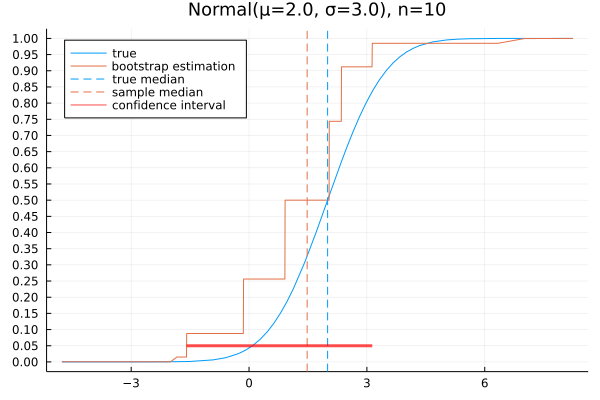

In [6]:
plot_randmedianci(Normal(2, 3), 10; α = 0.05)

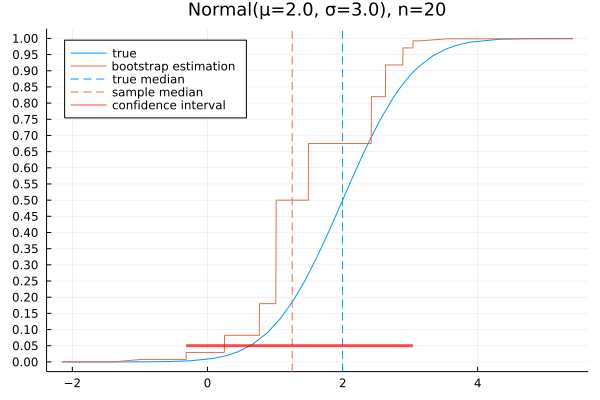

In [7]:
plot_randmedianci(Normal(2, 3), 20; α = 0.05)

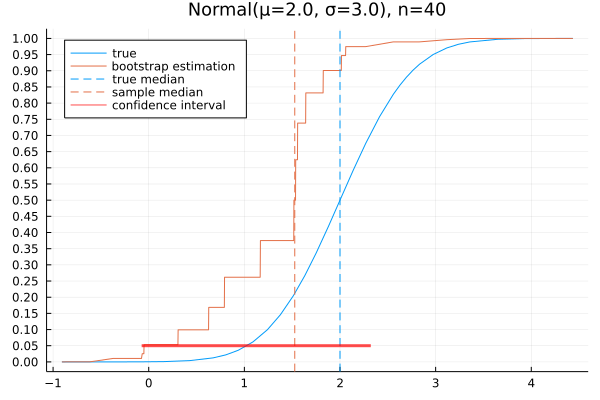

In [8]:
plot_randmedianci(Normal(2, 3), 40; α = 0.05)

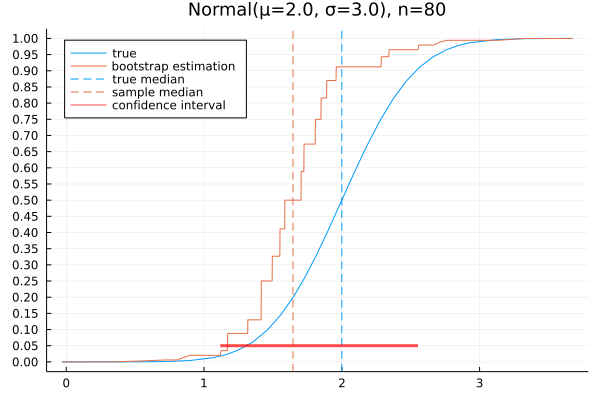

In [9]:
plot_randmedianci(Normal(2, 3), 80; α = 0.05)

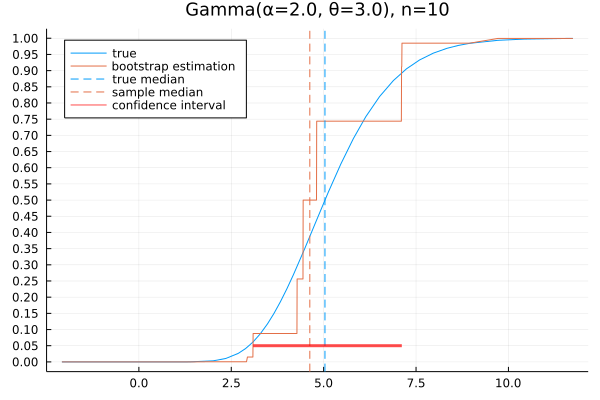

In [10]:
plot_randmedianci(Gamma(2, 3), 10; α = 0.05)

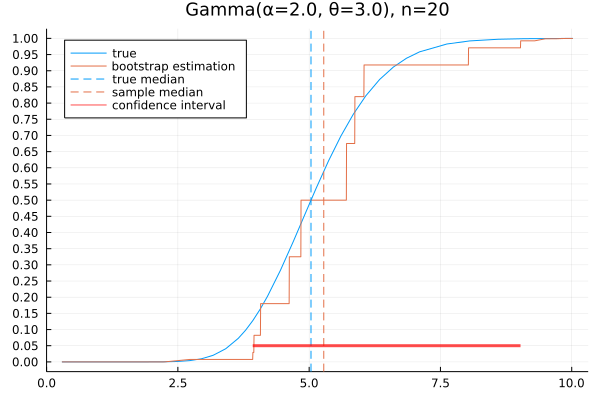

In [11]:
plot_randmedianci(Gamma(2, 3), 20; α = 0.05)

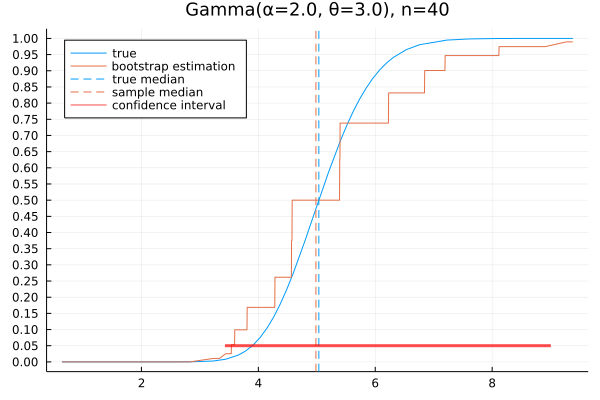

In [12]:
plot_randmedianci(Gamma(2, 3), 40; α = 0.05)

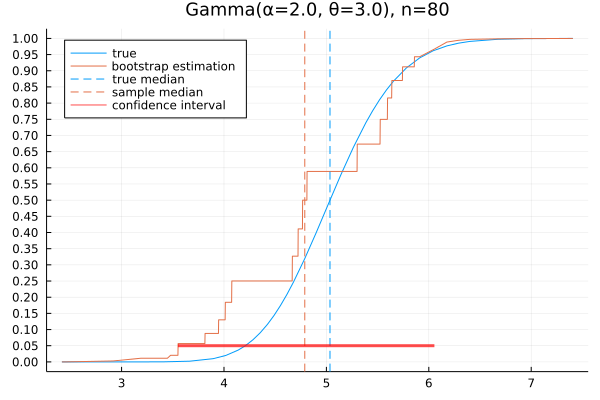

In [13]:
plot_randmedianci(Gamma(2, 3), 80; α = 0.05)

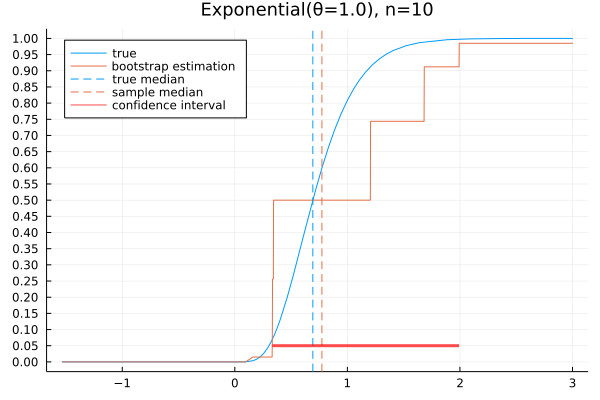

In [14]:
plot_randmedianci(Exponential(), 10; α = 0.05)

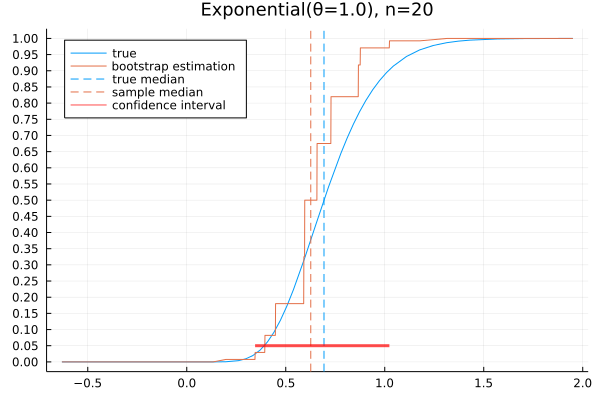

In [15]:
plot_randmedianci(Exponential(), 20; α = 0.05)

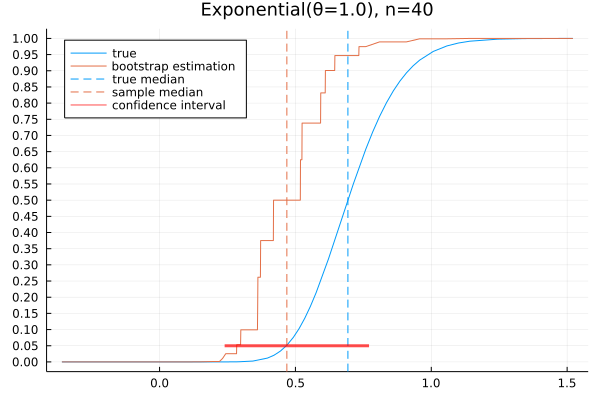

In [16]:
plot_randmedianci(Exponential(), 40; α = 0.05)

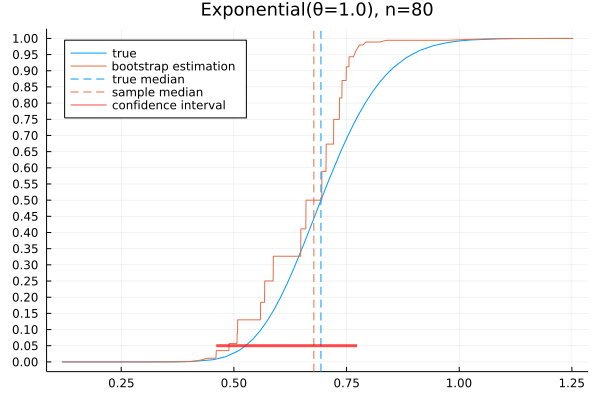

In [17]:
plot_randmedianci(Exponential(), 80; α = 0.05)

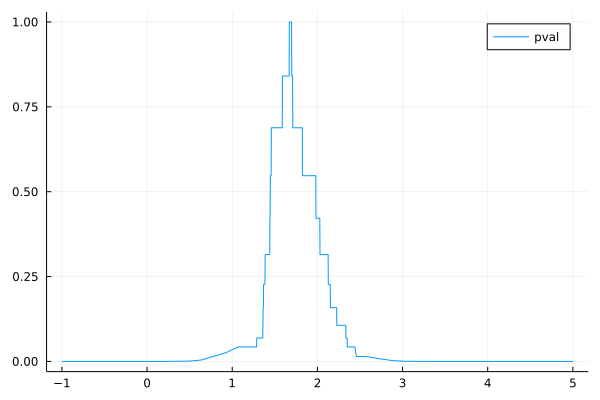

In [18]:
dist, n = Normal(2, 3), 100
X = rand(dist, n)
plot(x -> pvalmedian(X, x), -1, 5; label="pval")

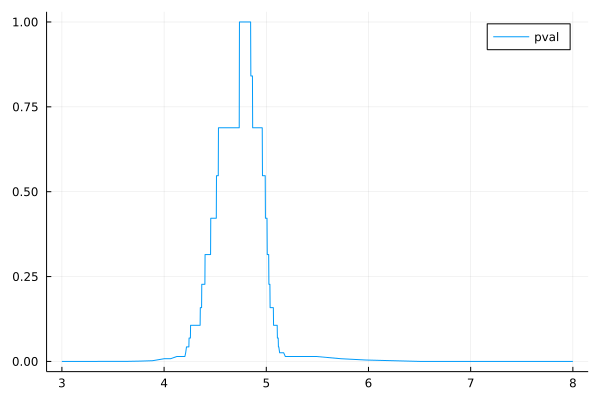

In [19]:
dist, n = Gamma(2, 3), 100
X = rand(dist, n)
plot(x -> pvalmedian(X, x), 3, 8; label="pval")

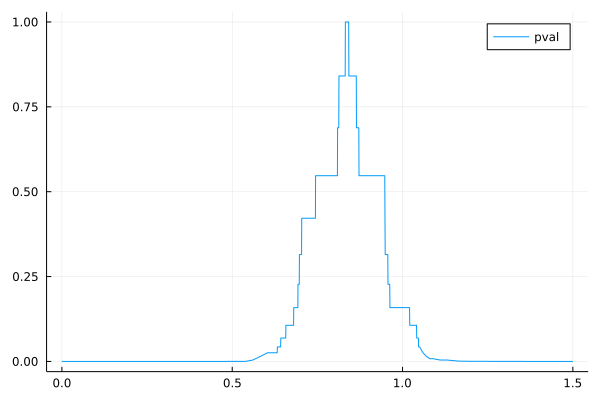

In [20]:
dist, n = Exponential(), 100
X = rand(dist, n)
plot(x -> pvalmedian(X, x), 0, 1.5; label="pval")

In [21]:
function sim_mediantest(dist, n; L = 10^5)
    a = median(dist)
    pval = Vector{Float64}(undef, L)
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        X = rand!(dist, tmp[Threads.threadid()])
        pval[i] = pvalmedian(X, a)
    end
    pval
end

function plot_mediantest(dist, n; L = 10^5)
    pval = sim_mediantest(dist, n; L)
    m = median(dist)
    s = std(dist)/√n
    plot(; legend=false)
    plot!(a -> ecdf(pval)(a), 0, 0.1; label="ecdf of pvalues")
    plot!([0, 0.1], [0, 0.1]; label="", c=:black, ls=:dot)
    plot!(; xtick=0:0.01:1, ytick=0:0.01:1)
    plot!(; size=(400, 400))
end

plot_mediantest (generic function with 1 method)

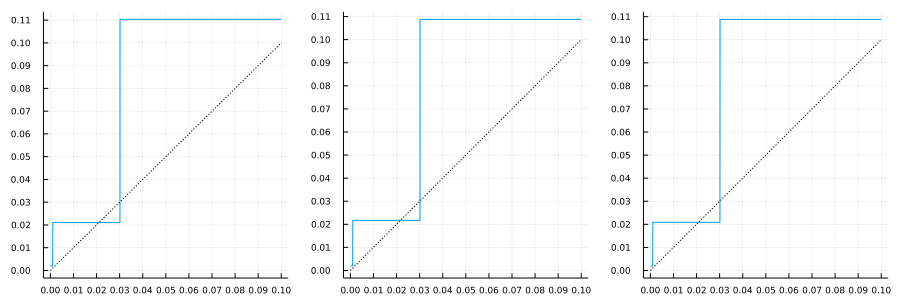

In [22]:
n = 10
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

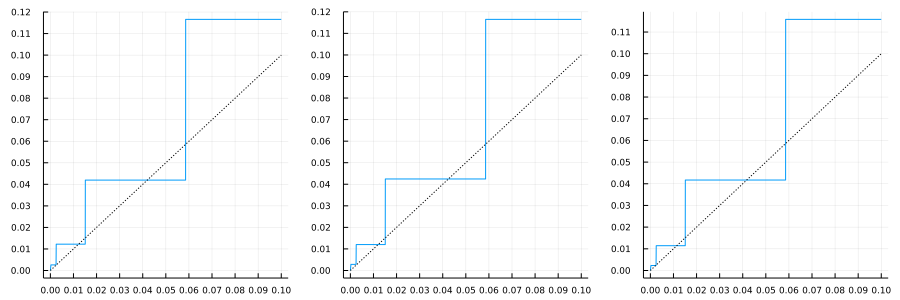

In [23]:
n = 20
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

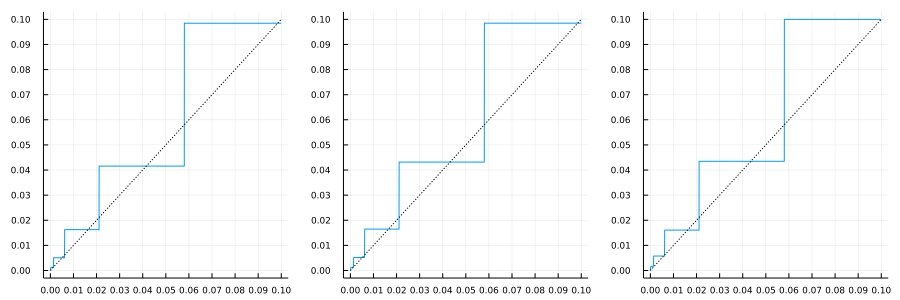

In [24]:
n = 30
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

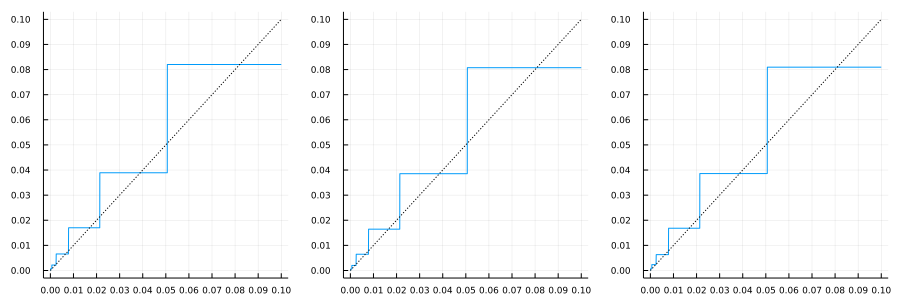

In [25]:
n = 40
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

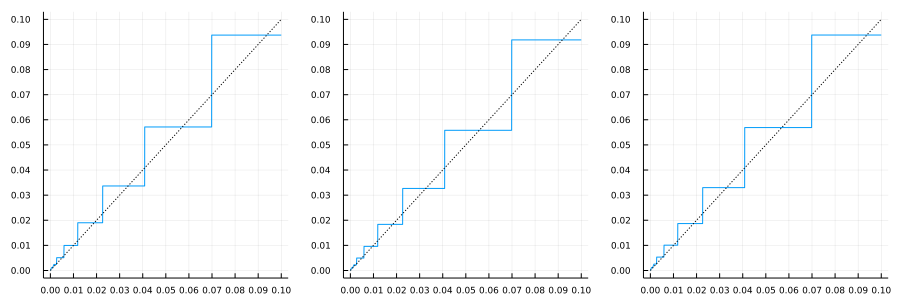

In [26]:
n = 80
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

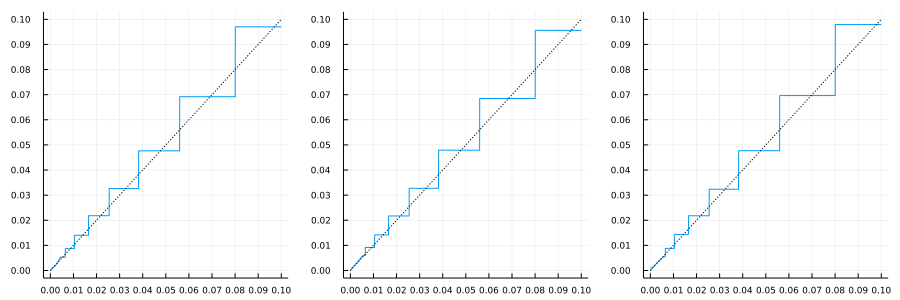

In [27]:
n = 160
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

観察: 第一種の過誤が起こる確率は母集団分布によらずに決まっている.

In [28]:
dist, n = Gamma(2, 3), 10
X = rand(dist, n)
Y = -4.0:n-5
@show cdfX = cdfmedian.(Ref(X), sort(X))
@show cdfY = cdfmedian.(Ref(Y), Y)
@show cdfX == cdfY
println()
@show pmfX = pmfmedian.(Ref(X), sort(X))
@show sum(pmfX)
@show pmfY = pmfmedian.(Ref(Y), Y)
@show sum(pmfY)
@show pmfX == pmfY
println()
@show pvalX = pvalmedian.(Ref(X), sort(X))
@show pvalY = pvalmedian.(Ref(Y), Y)
@show pvalX == pvalY;

cdfX = cdfmedian.(Ref(X), sort(X)) = [0.0005124147287938938, 0.01508539758278693, 0.0878257877375041, 0.25619489936789985, 0.49999999999999994, 0.7438051006321001, 0.9121742122624958, 0.9849146024172131, 0.9994875852712062, 1.0]
cdfY = cdfmedian.(Ref(Y), Y) = [0.0005124147287938938, 0.01508539758278693, 0.0878257877375041, 0.25619489936789985, 0.49999999999999994, 0.7438051006321001, 0.9121742122624958, 0.9849146024172131, 0.9994875852712062, 1.0]
cdfX == cdfY = true

pmfX = pmfmedian.(Ref(X), sort(X)) = [0.0005124147287938938, 0.014572982853993036, 0.07274039015471717, 0.16836911163039575, 0.2438051006321001, 0.2438051006321002, 0.1683691116303957, 0.07274039015471723, 0.01457298285399311, 0.0005124147287938197]
sum(pmfX) = 1.0
pmfY = pmfmedian.(Ref(Y), Y) = [0.0005124147287938938, 0.014572982853993036, 0.07274039015471717, 0.16836911163039575, 0.2438051006321001, 0.2438051006321002, 0.1683691116303957, 0.07274039015471723, 0.01457298285399311, 0.0005124147287938197]
sum(pmfY) = 1.0
p

このように, 任意のサイズ $n$ のサンプル $X_1<X_2<\cdots<X_n$ から得られるP値函数の $X_i$ における値と, $1<2<\cdots<n$ から得られるP値函数の $i$ における値は等しくなる.

X = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 3.0, 2.0, 1.0, 4.0, 3.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]
Xdist = empiricaldist_allowrep(X) = DiscreteNonParametric{Float64, Float64, Vector{Float64}, Vector{Float64}}(
support: [1.0, 2.0, 3.0, 4.0, 5.0]
p: [0.3, 0.2, 0.1, 0.1, 0.3]
)

n = 10 = 10


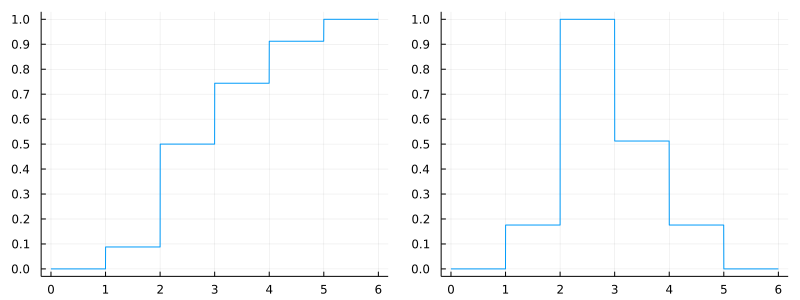

In [29]:
X = Float64[5, 5, 5, 5, 5, 5, 4, 3, 2, 1, 4, 3, 2, 1, 2, 2, 1, 1, 1, 1]
@show X
@show Xdist = empiricaldist_allowrep(X)
@show n = 10
P1 = plot(x -> cdfmedian(Xdist, n, x), 0, 6; label="", ytick=0:0.1:1)
P2 = plot(x -> pvalmedian(Xdist, n, x), 0, 6; label="", ytick=0:0.1:1)
plot(P1, P2; size=(800, 300))

X = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 3.0, 2.0, 1.0, 4.0, 3.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]
Xdist = DiscreteNonParametric{Float64, Float64, Vector{Float64}, Vector{Float64}}(
support: [1.0, 2.0, 3.0, 4.0, 5.0]
p: [0.3, 0.2, 0.1, 0.1, 0.3]
)

n = 15


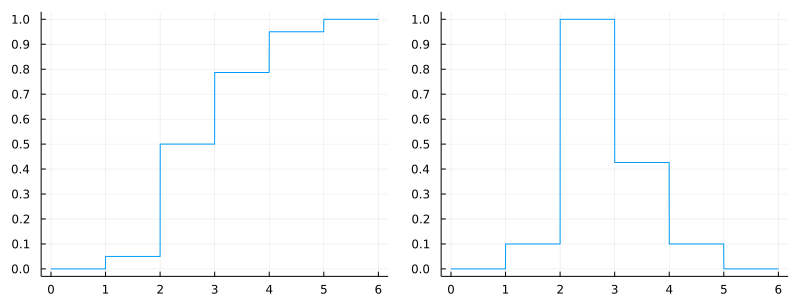

In [30]:
X = Float64[5, 5, 5, 5, 5, 5, 4, 3, 2, 1, 4, 3, 2, 1, 2, 2, 1, 1, 1, 1]
Xdist = Xdist = empiricaldist_allowrep(X)
n = 15
@show X
@show Xdist
@show n
P1 = plot(x -> cdfmedian(Xdist, n, x), 0, 6; label="", ytick=0:0.1:1)
P2 = plot(x -> pvalmedian(Xdist, n, x), 0, 6; label="", ytick=0:0.1:1)
plot(P1, P2; size=(800, 300))

## RのDescToolsによる中央値の信頼区間の計算との比較

https://stats.stackexchange.com/questions/502977/confidence-interval-for-median-which-is-more-appropriate-bootstrap-or-binom-ex

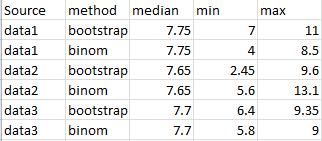

In [31]:
using RCall
R"library(DescTools)"

┌ Warning: RCall.jl: Warning: package 'DescTools' was built under R version 4.1.2
└ @ RCall D:\.julia\packages\RCall\6kphM\src\io.jl:172


RObject{StrSxp}
[1] "DescTools" "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     


In [32]:
X = data1 = [8,    7,  8,  9.5,    1,  20, 8,  7.5,    3,  20.5,   2.5,    5.5,    15.5,   2,  4,  1,
    17,   2,  3.5,    8.5,    8.5,    2.5,    11, 4,  10.5,   7.5,    12, 5,  16.5,   8.5]
Y = X + [√eps()*randn() for _ in 1:length(X)]
@show cimedian_allowrep(X)
@show cimedian(Y)
println()
@rput data1
@show R"""MedianCI(data1, na.rm = TRUE, method = "boot")"""
@show R"""MedianCI(data1, na.rm = TRUE, method = "exact")""";

cimedian_allowrep(X) = (4.0, 8.5)
cimedian(Y) = (4.000000020581541, 8.500000021032042)

R"MedianCI(data1, na.rm = TRUE, method = \"boot\")" = RObject{RealSxp}
median lwr.ci upr.ci 
  7.75   7.00  11.00 

R"MedianCI(data1, na.rm = TRUE, method = \"exact\")" = RObject{RealSxp}
median lwr.ci upr.ci 
  7.75   4.00   8.50 
attr(,"conf.level")
[1] 0.9572261



In [33]:
X = data2 = [7.1,  32.0,   3.8,    1.6,    19.6,   6.0,    7.2,    14.9,   0,  2.0,    5.7,
          19.4, 13.1,   15.5,   11.3,   9.6,    13.9,   5.6,    12.6,   1.0,    1.9,
          8.1,  15.9,   0.8,    6.1,    8.1,    18.0,   4.6,    5.5,    15.6]
Y = X + [√eps()*randn() for _ in 1:length(X)]
@show cimedian_allowrep(X)
@show cimedian(Y)
println()
@rput data2
@show R"""MedianCI(data2, na.rm = TRUE, method = "boot")"""
@show R"""MedianCI(data2, na.rm = TRUE, method = "exact")""";

cimedian_allowrep(X) = (5.6, 13.1)
cimedian(Y) = (5.600000024527222, 13.099999993021038)

R"MedianCI(data2, na.rm = TRUE, method = \"boot\")" = RObject{RealSxp}
median lwr.ci upr.ci 
  7.65   2.45   9.65 

R"MedianCI(data2, na.rm = TRUE, method = \"exact\")" = RObject{RealSxp}
median lwr.ci upr.ci 
  7.65   5.60  13.10 
attr(,"conf.level")
[1] 0.9572261



In [34]:
X = data3 = [16.1, 10.4,   0.5,    12.2,   7.2,    1.7,    21.6,   6.3,    0.8,    3.2,    12.6,   20.0,   3.4, 7.3,   3.5,
          7.5,  15.8, 4.7, 8.3, 11.9,   1.6,    9.0, 8.6,   11.7,   8.1, 5.8, 3.3,  7.9,    7.0,    8.5]
Y = X + [√eps()*randn() for _ in 1:length(X)]
@show cimedian_allowrep(X)
@show cimedian(Y)
println()
@rput data3
@show R"""MedianCI(data3, na.rm = TRUE, method = "boot")"""
@show R"""MedianCI(data3, na.rm = TRUE, method = "exact")""";

cimedian_allowrep(X) = (5.8, 9.0)
cimedian(Y) = (5.800000019951465, 9.000000011778466)

R"MedianCI(data3, na.rm = TRUE, method = \"boot\")" = RObject{RealSxp}
median lwr.ci upr.ci 
  7.70   6.40   9.45 

R"MedianCI(data3, na.rm = TRUE, method = \"exact\")" = RObject{RealSxp}
median lwr.ci upr.ci 
   7.7    5.8    9.0 
attr(,"conf.level")
[1] 0.9572261



https://github.com/cran/DescTools/blob/d5e096ee9abf4640703dfba45d1ed56b5ab10253/R/StatsAndCIs.r#L3690

* https://www.stat.umn.edu/geyer/old03/5102/notes/rank.pdf
* https://www.scribd.com/presentation/75941305/Confidence-Interval-for-Median-Based-on-Sign-Test
* https://stat.ethz.ch/pipermail/r-help/2003-September/039636.html

このノートで実装した中央値の信頼区間は "SAS-way" と同じもののようだ.